<div class="div_image pull-right">
    <div class = "image image_topic pull-right">
        <img src = "https://i.imgur.com/EGtMXKh.jpg?1">
    </div>
</div>

# <b>Capstone Project: Predicting Dota 2 Match Wins using Machine Learning and Recommender System (Neural Network)</b>


In Part 3, we tried out several machine learning models to predict the winrate of our data. In this part, we will build a neural network to determine if we can better our match predictions.


# Import Libraries


In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Lambda, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.math import confusion_matrix, round
from tensorboard.plugins.hparams import api as hp
from keras.wrappers.scikit_learn import KerasClassifier
import keras_tuner
from keras.callbacks import TensorBoard

import datetime

import shap

import warnings

warnings.filterwarnings('ignore')


In [16]:
# Load TensorBoard

%load_ext tensorboard


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


# Data Preprocessing


We will load in our preprocessed data and map the values to win or lose accordingly. A radiant_win will be noted as a 1, while a dire_win would be 0.


In [17]:
# Import CSV
model_df = pd.read_csv("preprocessed_data.csv")


model_df.shape


(82380, 247)

In [18]:
# Mapping our Win and Loss values
model_df['radiant_win'] = model_df['radiant_win'].map({False: 0, True: 1})


## Generate Holdout Set

We will set aside 5% of our data as a holdout set that our model can use to predict on once trained and validated.


In [19]:
# Create Holdout set

data = model_df.sample(frac=0.95, random_state=42)
data_unseen = model_df.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))


Data for Modeling: (78261, 247)
Unseen Data For Predictions: (4119, 247)


## Generate Validation Set

From here, we see that we have kept 4119 rows of data as our holdout set. We will then train on our training set


In [20]:
# Train Test Split Data
X = data.drop("radiant_win", axis=1)
y = data["radiant_win"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, test_size=0.2)


In [21]:
# Value count of each label
y_train.value_counts()


0    31403
1    31205
Name: radiant_win, dtype: int64

After spliting, we see that our target variable in our train data still remains balanced.


# Tensorflow Model


I will be using tensorflow to help us build our neural network model. The network input is a binary vector of 246 values, which is then divided into two parts - _x_radiant, and x_dire_ - using Keras Lambda Layers, then two Dense layers - _hero_layer_1 and hero_layer_2_ - are applied to each of the lambda layers. This is necessary to remove the influence of the heroes on the "dire" and "radiant" team accordingly. The resulting vectors are then concatenated. The vectors are then put through two dropout layers, before alternating three cycles of hidden layers and dropout layers. The output layer is a Dense Layer with 1 neuron and Sigmoid Activation function.

I will be using 'adam' as my optimiser and optimise for accuracy and will be using Keras Tuner's HyperBand to optimise the hyperparameters.


In [22]:
# Tensorflow model - Reference from 'Machine Learning Approaches to Choose Heroes in Dota 2' by Iullia Porokhnenko, Petr Polezhaev and Alexander Shukhman

# Function to create model
def create_model(hp):
    # Input Layer

    # to determine the shape of the input
    input_columns = int(len(model_df.columns) - 1)
    input = Input(shape=(input_columns,))

    # int value between min and max value
    dense_units = hp.Int('dense_units', min_value=320, max_value=512, step=32)
    hidden_units_1 = hp.Int(
        'hidden_units_1', min_value=288, max_value=480, step=32)
    hidden_units_2 = hp.Int(
        'hidden_units_2', min_value=288, max_value=448, step=32)
    hidden_units_3 = hp.Int(
        'hidden_units_3', min_value=288, max_value=416, step=32)
    # dropout rate of 0.3 to 0.5
    dropout = hp.Choice('dropout', [0.3, 0.4, 0.5])
    # different learning rate
    learning_rate_1 = hp.Choice('learning_rate_1', [0.001, 0.002, 0.0005])

    # Lamda Layer for x_radiant heroes
    x_radiant = Lambda(lambda x: x[:, :int(input_columns/2)])(input)

    # Lamda Layer for x_dire heroes
    x_dire = Lambda(lambda x: x[:, int(input_columns/2):])(input)

    # Dense Layer of Number of Units in First Layer Neurons

    hero_layers_1 = Dense(dense_units, activation='relu')

    # Apply to x_dire

    dire_layer_1 = hero_layers_1(x_dire)

    # Apply to x_radiant
    radiant_layer_1 = hero_layers_1(x_radiant)

    # Apply Dense Layer 1 again

    hero_layers_2 = Dense(dense_units, activation='relu')

    # Apply to dire layer 1

    dire_layer_2 = hero_layers_2(dire_layer_1)

    # Apply to radiant layer 2

    radiant_layer_2 = hero_layers_2(radiant_layer_1)

    # Combine the 2 layers

    conc = concatenate([dire_layer_2, radiant_layer_2])

    # Apply 2 dropout regularization layers

    dropout1 = Dropout(dropout)(conc)
    dropout2 = Dropout(dropout)(dropout1)

    # Apply hidden layer 1

    hidden1 = Dense(hidden_units_1, activation='relu')(dropout2)

    # Dropout Regularization 1

    dropout_hidden1 = Dropout(dropout)(hidden1)

    # Apply hidden layer 2

    hidden2 = Dense(hidden_units_2, activation='relu')(dropout_hidden1)

    # Dropout Regularization 2

    dropout_hidden2 = Dropout(dropout)(hidden2)

    # Apply hidden layer 3

    hidden3 = Dense(hidden_units_3, activation='relu')(dropout_hidden2)

    # Output Layer
    output = Dense(1, activation='sigmoid')(hidden3)

    # Final Model

    model = Model(inputs=input, outputs=output)

    opt = Adam(learning_rate=learning_rate_1)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt, metrics=['accuracy'])

    return model


In [23]:
# Creating our model
create_model(keras_tuner.HyperParameters())


I will set the tuner to optimise for validation accuracy. I will also set a max epoch value of 80 and log the results.

In addition, I will create a stop-early function to also ensure that our model does not overfit. I have set the patience function for the validation loss to 2, which indicates that each trial will stop early should the validation loss increases two times in a row.


In [24]:
# Creating our tuner and boundaries
tuner = keras_tuner.Hyperband(
    hypermodel=create_model,
    objective="val_accuracy",
    max_epochs=50,
    seed=123,
    factor=5,
    overwrite=True,
    project_name="hyperparameter_search_results",
)


In [25]:
# Creating a stop-early function
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)


I will now instantiate the tuner onto the model to search through the best parameters.


In [26]:
# Instantiate the tuner onto the model
tuner.search(X_train, y_train, validation_data=(X_test, y_test),
             callbacks=[stop_early], epochs=80, batch_size=64)


Trial 59 Complete [00h 01m 20s]
val_accuracy: 0.7930747866630554

Best val_accuracy So Far: 0.852232813835144
Total elapsed time: 00h 32m 05s
INFO:tensorflow:Oracle triggered exit


In [27]:
# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Dense Units is {best_hps['dense_units']}")
print(f"Best Hidden 1 Units is {best_hps['hidden_units_1']}")
print(f"Best Hidden 2 Units is {best_hps['hidden_units_2']}")
print(f"Best Hidden 3 Units is {best_hps['hidden_units_3']}")
print(f"Best Dropout Regularisation is {best_hps['dropout']}")
print(f"Best Learning Rate is {best_hps['learning_rate_1']}")


Best Dense Units is 480
Best Hidden 1 Units is 320
Best Hidden 2 Units is 352
Best Hidden 3 Units is 288
Best Dropout Regularisation is 0.3
Best Learning Rate is 0.002


From the above, we can see the best hyperparameters for our model. We will then train our model with these hyperparameters and plot the graph to show the loss and accuracy.


In [34]:

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1)

model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=20, validation_data=(
    X_test, y_test), callbacks=[tensorboard_callback], batch_size=64)


Epoch 1/20
979/979 [==============================] - 7s 7ms/step - loss: 0.6894 - accuracy: 0.5395 - val_loss: 0.6840 - val_accuracy: 0.5721
Epoch 2/20
979/979 [==============================] - 6s 6ms/step - loss: 0.6775 - accuracy: 0.5789 - val_loss: 0.6710 - val_accuracy: 0.5906
Epoch 3/20
979/979 [==============================] - 6s 6ms/step - loss: 0.6453 - accuracy: 0.6317 - val_loss: 0.6509 - val_accuracy: 0.6228
Epoch 4/20
979/979 [==============================] - 6s 6ms/step - loss: 0.5809 - accuracy: 0.7020 - val_loss: 0.6212 - val_accuracy: 0.6609
Epoch 5/20
979/979 [==============================] - 7s 7ms/step - loss: 0.4963 - accuracy: 0.7650 - val_loss: 0.6006 - val_accuracy: 0.6972
Epoch 6/20
979/979 [==============================] - 6s 6ms/step - loss: 0.4049 - accuracy: 0.8199 - val_loss: 0.5710 - val_accuracy: 0.7381
Epoch 7/20
979/979 [==============================] - 6s 6ms/step - loss: 0.3267 - accuracy: 0.8633 - val_loss: 0.5409 - val_accuracy: 0.7664
Epoch 

## Model Plots


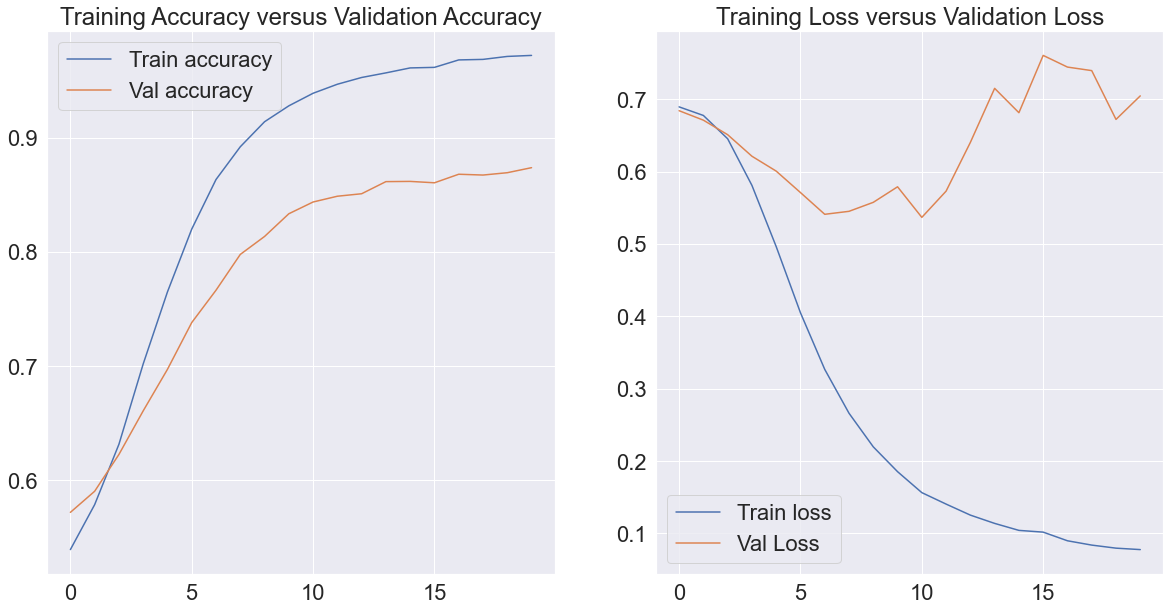

In [35]:
# Plotting Model on Validation Loss and Accuracy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.plot(history.history['accuracy'], label='Train accuracy')
ax1.plot(history.history['val_accuracy'], label='Val accuracy')
ax1.set_title("Training Accuracy versus Validation Accuracy")
ax1.legend()

ax2.plot(history.history['loss'], label='Train loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title("Training Loss versus Validation Loss")
ax2.legend()


There are a few observations from the graphs:

1. The model at the end of the fitting achieved a training accuracy of 95.6% and validation accuracy of 87.4%, substantially higher than our traditional machine learning models.

2. The accuracy for both the training and validation set seems to increase beyond the chosen epochs as it is still increasing at the end and has not levelled off.

3. However, I can see that while the training loss is still decreasing, the validation loss has started to plateau. This would suggest that model will soon overfit even if the number of epochs increases.

Based on the model, I would want to choose the point at the lowest validation loss. The plateau lies between epoch 11 and epoch 12 so either number should be fine. I have chosen epochs 12 to train our model on the full training dataset.


## Predicting on holdout set


The model shall now be trained on the full training set to test on our holdout set.


In [39]:
# Training on the full training set
hypermodel = tuner.hypermodel.build(best_hps)

final_model = hypermodel.fit(X, y, epochs=12, batch_size=64)


Epoch 1/12
1223/1223 [==============================] - 7s 5ms/step - loss: 0.6886 - accuracy: 0.5424
Epoch 2/12
1223/1223 [==============================] - 6s 5ms/step - loss: 0.6715 - accuracy: 0.5926
Epoch 3/12
1223/1223 [==============================] - 6s 5ms/step - loss: 0.6217 - accuracy: 0.6602
Epoch 4/12
1223/1223 [==============================] - 6s 5ms/step - loss: 0.5332 - accuracy: 0.7368
Epoch 5/12
1223/1223 [==============================] - 6s 5ms/step - loss: 0.4263 - accuracy: 0.8046
Epoch 6/12
1223/1223 [==============================] - 6s 5ms/step - loss: 0.3283 - accuracy: 0.8591
Epoch 7/12
1223/1223 [==============================] - 6s 5ms/step - loss: 0.2544 - accuracy: 0.8954
Epoch 8/12
1223/1223 [==============================] - 6s 5ms/step - loss: 0.2037 - accuracy: 0.9193
Epoch 9/12
1223/1223 [==============================] - 6s 5ms/step - loss: 0.1689 - accuracy: 0.9341
Epoch 10/12
1223/1223 [==============================] - 6s 5ms/step - loss: 0.140

We obtain an accuracy of 95.8% on our full training set.


In [40]:
# Creating X and y holdouts
X_holdout = data_unseen.drop(columns=["radiant_win"])
y_holdout = data_unseen['radiant_win']


We can create a confusion matrix to see the display our predictions.


In [46]:
# Generate y prediction values rounded to either 0 or 1

y_pred = round(hypermodel.predict(X_holdout))

print(y_pred)


129/129 [==============================] - 0s 2ms/step
tf.Tensor(
[[1.]
 [1.]
 [1.]
 ...
 [1.]
 [0.]
 [0.]], shape=(4119, 1), dtype=float32)


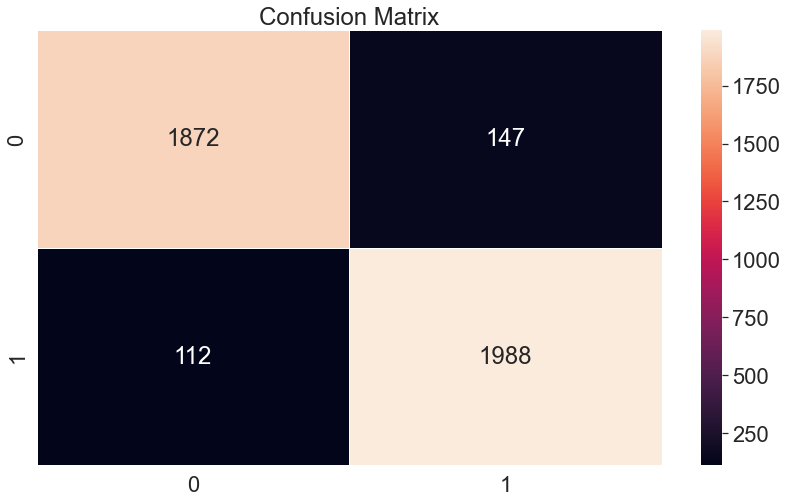

In [47]:
# Generating our confusion matrix

cm = confusion_matrix(y_holdout, y_pred)

plt.figure(figsize=(14, 8))
sns.set(font_scale=2)
p = sns.heatmap(data=cm, annot=True, fmt='d',
                linewidths=.5).set(title='Confusion Matrix')


From the above, we see that the model have predicted 1988 true positives and 1872 true negatives, corresponding to an accuracy of 93.7%, which is very close to our training accuracy. The model predicts 112 false negatives and 147 false positives, which is relatively even between the two.

# Shap Values


We can use Shap Values to interpret our black box model to have a sense of which are the highest contributing features. To minimise processing time, we will be extracting 10% of the train and holdout data to be processed.


In [43]:
# Compute Shap Values

background = X.iloc[np.random.choice(X.shape[0], 7800, replace=False)]

explainer = shap.DeepExplainer(model, background.values)

shap_values = explainer.shap_values(X_holdout[:300].values)


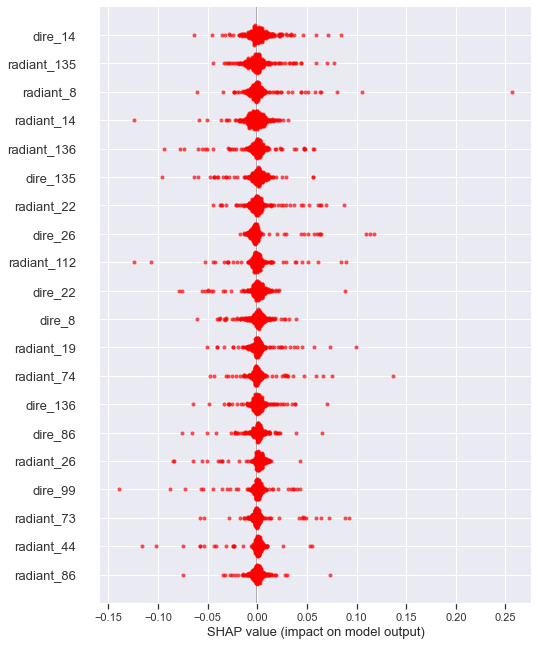

In [50]:
#Plotting in pairs
shap.summary_plot(shap_values[0],  feature_names=X_holdout.columns,
                  color='red', alpha=0.7, title='Top Features')


There are a few observations we can gather from the graphs above:

1. Generally, the observations come in pairs (e.g. Radiant_14 and Dire_14 have), which is unsurprising given that teams are randomly assigned. As such, given that we had tried to normalise the skill level between players by choosing only high ranking matches, the hero choice should produce similar contribution from both teams.

2. There are very few overlaps with the individual win rates. Look at the shap values, the top contributing heroes seem to be:

- Pudge
- Dawnbreaker
- Juggernaut
- Marci
- Zeus
- Lion
- Winter Wyvern

  With the exception of Lion, who appears in our list of heroes with the lowest win rates, it seems that individual win rates do not contribute as much to the overall success of the match and that hero synergies could play a bigger overall role in a match's win rate.


In [49]:
# Plotting individual sample shap value
shap.initjs()
shap.force_plot(explainer.expected_value[0].numpy(
), shap_values[0][110], features=X_holdout.columns, out_names='Probability')


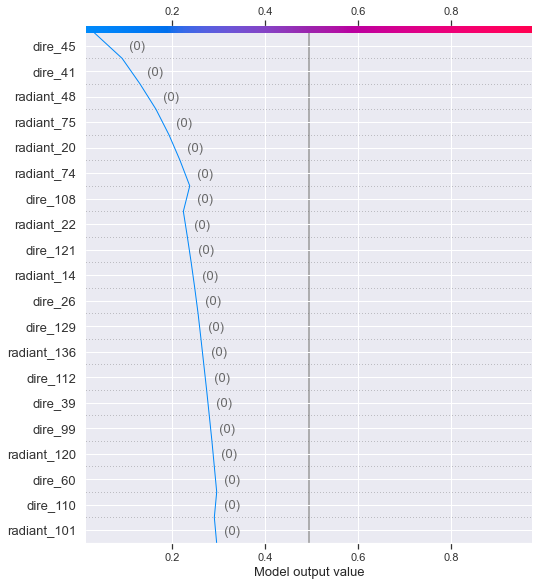

In [54]:
# Plotting individual sample shap decision plot
shap.decision_plot(explainer.expected_value[0].numpy(
), shap_values[0][110], features=X_holdout.iloc[0, :], feature_names=X_holdout.columns.tolist())


In [55]:
# Saving the model file
model.save('model.h5')
